# MAE Pretrain Visualise Demo

In [2]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

sys.path.append('/cs/student/projects3/COMP0197/grp3/adl_groupwork/mae/models_mae_sam_ft.py')
import models_mae_sam_ft

sys.path.append('/cs/student/projects3/COMP0197/grp3/adl_groupwork/mae/models_mae.py')
import models_mae

ModuleNotFoundError: No module named 'models_mae_sam_ft'

In [15]:
# Functions 

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    # CHANGE
    # if img.ndim == 3:
    #     img = img.unsqueeze(dim=0)

    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

# def show_image(image, title=''):
#     # Assuming image is a numpy array of shape [H, W, 3]
#     image = image.permute(2, 0, 1)  # Convert to [3, H, W]
#     image = (image * imagenet_std[:, None, None] + imagenet_mean[:, None, None]) * 255
#     image = image.permute(1, 2, 0).int().numpy()
#     plt.imshow(np.clip(image, 0, 255).astype(np.uint8))
#     plt.title(title, fontsize=16)
#     plt.axis('off')

# Show Sample Image

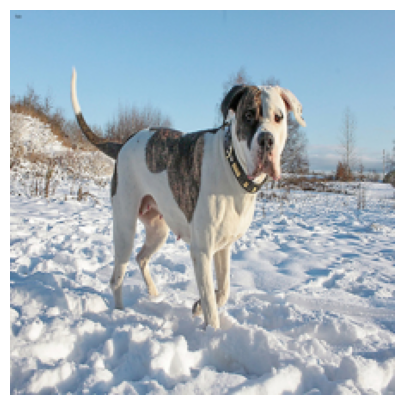

In [26]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

img_path = '/cs/student/projects3/COMP0197/grp3/adl_groupwork/OxfordPet/images/american_bulldog_97.jpg'
img = Image.open(img_path).convert('RGB')
img = img.resize((224, 224))
img = np.array(img) / 255.0

assert img.shape == (224, 224, 3)

# Normalize by ImageNet mean and std
img = (img - imagenet_mean) / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

# MAE model trained on animal dataset

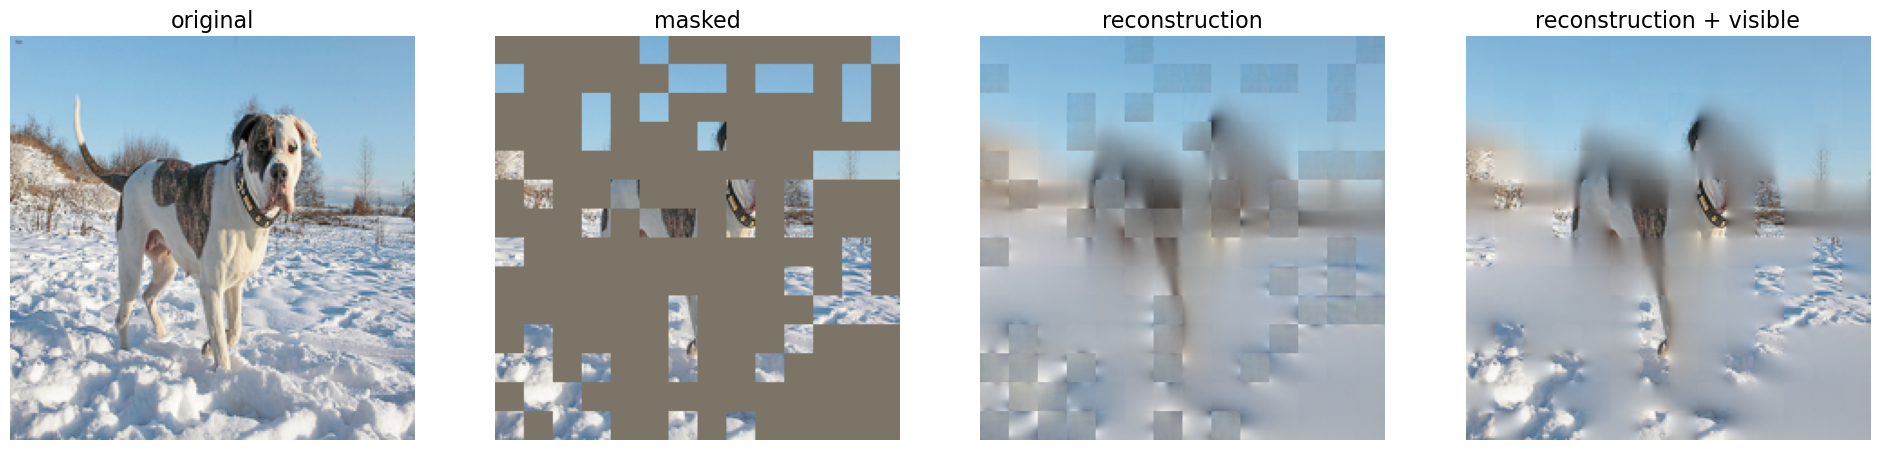

In [27]:

model = models_mae.mae_vit_base_patch16()

checkpoint_path = '/cs/student/projects3/COMP0197/grp3/adl_groupwork/mae/output_dir_judyAnimals/checkpoint-149.pth'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=False)


# Run the model and visualize
run_one_image(img, model)

# Using MAE model that was not trained on Animal Images

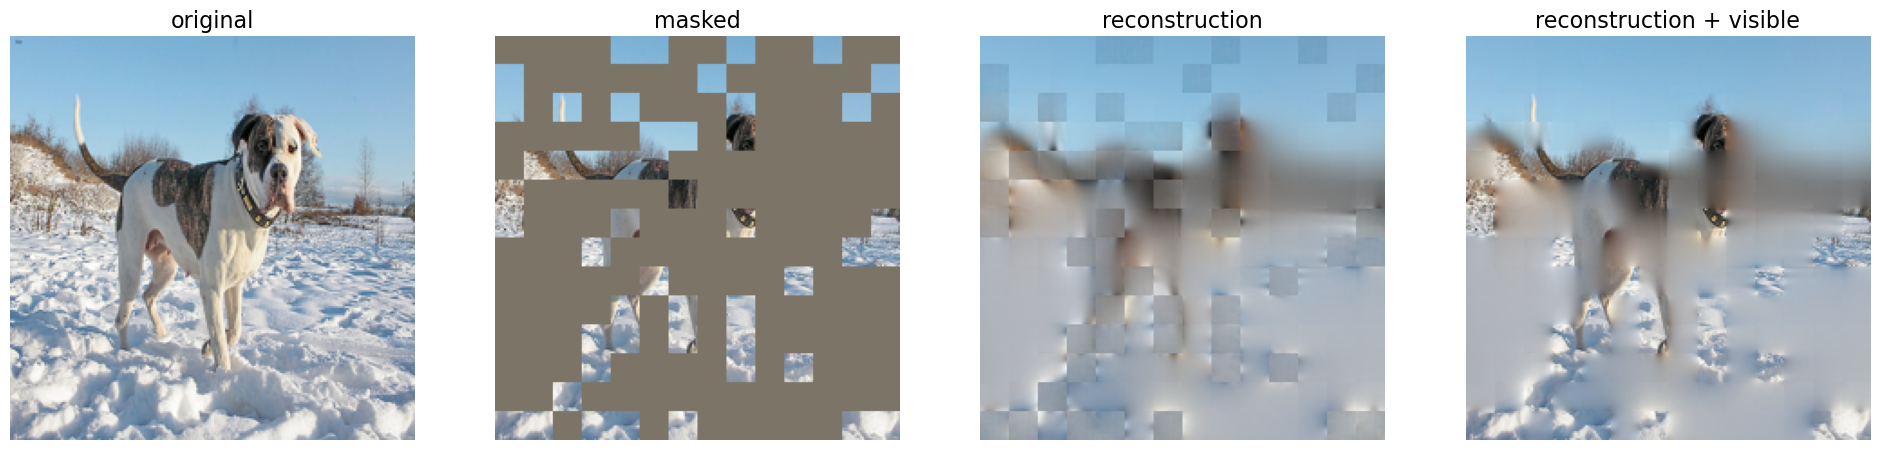

In [28]:
checkpoint_path = '/cs/student/projects3/COMP0197/grp3/adl_groupwork/mae/output_dir_judyNonanimals/checkpoint-149.pth'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=False)


# Run the model and visualize
run_one_image(img, model)

# Using MAE with mixed Animal and non-animal images

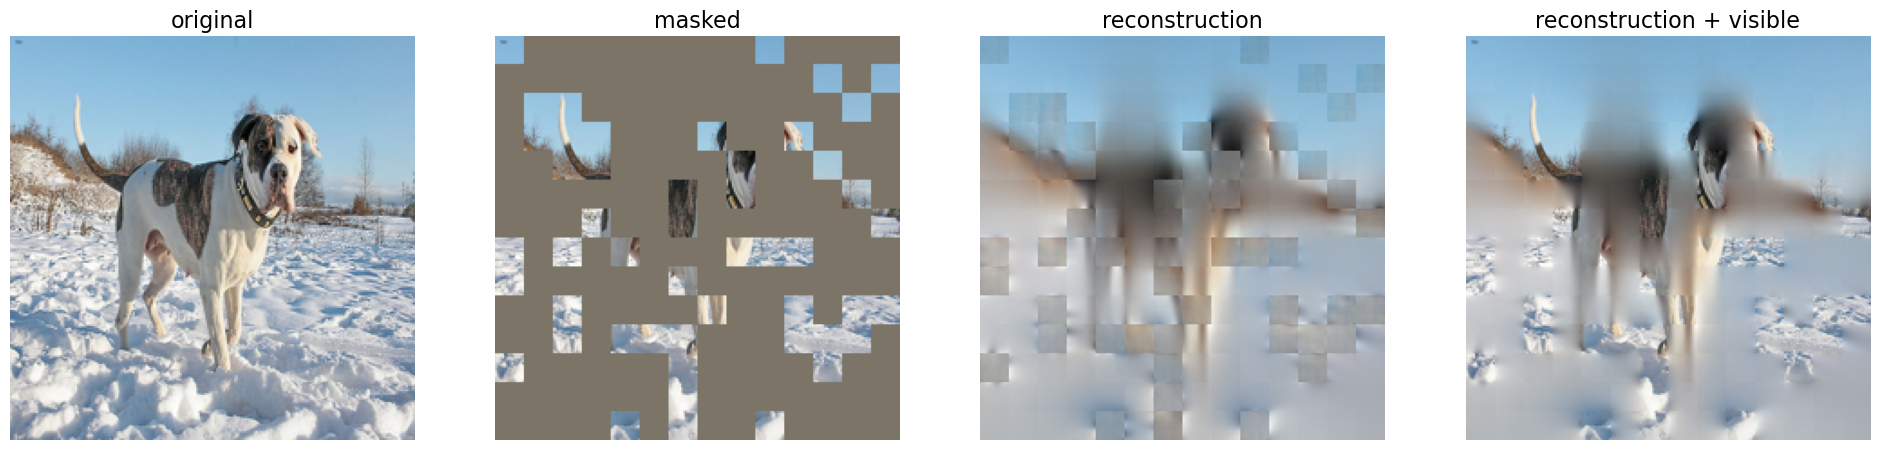

In [29]:
checkpoint_path = '/cs/student/projects3/COMP0197/grp3/adl_groupwork/mae/output_dir_anabel_mixed/checkpoint-149.pth'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=False)


# Run the model and visualize
run_one_image(img, model)